In [1]:
import thesis

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

plt.style.use("../thesis-style.mpl")

In [2]:
import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
#sys.path.insert(0, "../../..")
import pymc3 as pm

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd

In [261]:
hills = pd.read_csv("arrochar.csv")

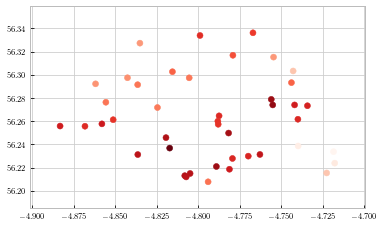

In [6]:
f, ax = plt.subplots(1,1, figsize=thesis.figsize)
ax.scatter(hills['lon'], hills['lat'], c=hills['height'], cmap='Reds')#, 'o', color='k')
#for i, txt in enumerate(n):
#plt.annotate(np.array(alps['height']), (np.array(alps['lat']), np.array(alps['lon'])))

In [7]:
lons = np.linspace(-4.85, -4.70, 20)
lats = np.linspace(56.20, 56.28, 20)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [8]:
cov_func = amp * pm.gp.cov.RatQuad(2, ls=ls, alpha=0.16994223)

In [9]:
X = points
K = cov_func(X).eval()

In [10]:
draws = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=1).T

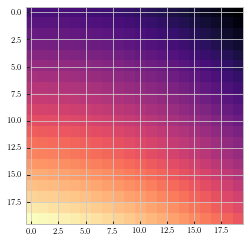

In [11]:
plt.imshow(draws.reshape(20,20))

In [238]:
with pm.Model() as model:
    
    amp = pm.Normal("amplitude", 1, 1)
    ls = [0.012, 0.012] #
    ls = pm.Normal("metric", mu=[0.012, 0.012], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.RatQuad(2, ls=ls, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)

In [239]:
with model:
    mp = pm.find_MAP()

logp = -17,796, ||grad|| = 746.49: 100%|██████████| 86/86 [00:00<00:00, 394.39it/s]          


In [240]:
mp

{'alpha': array([0.16994223]),
 'alpha_log__': array([-1.77229671]),
 'amplitude': array(109.108288),
 'metric': array([0.00830839, 0.00581033]),
 'sigma': array(0.10002128)}

In [241]:
lons = np.linspace(-4.9, -4.70, 150)
lats = np.linspace(56.20, 56.35, 150)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [242]:
with model:
    mu, var = gp.predict(points, point=mp, diag=True)
    sd = np.sqrt(var)

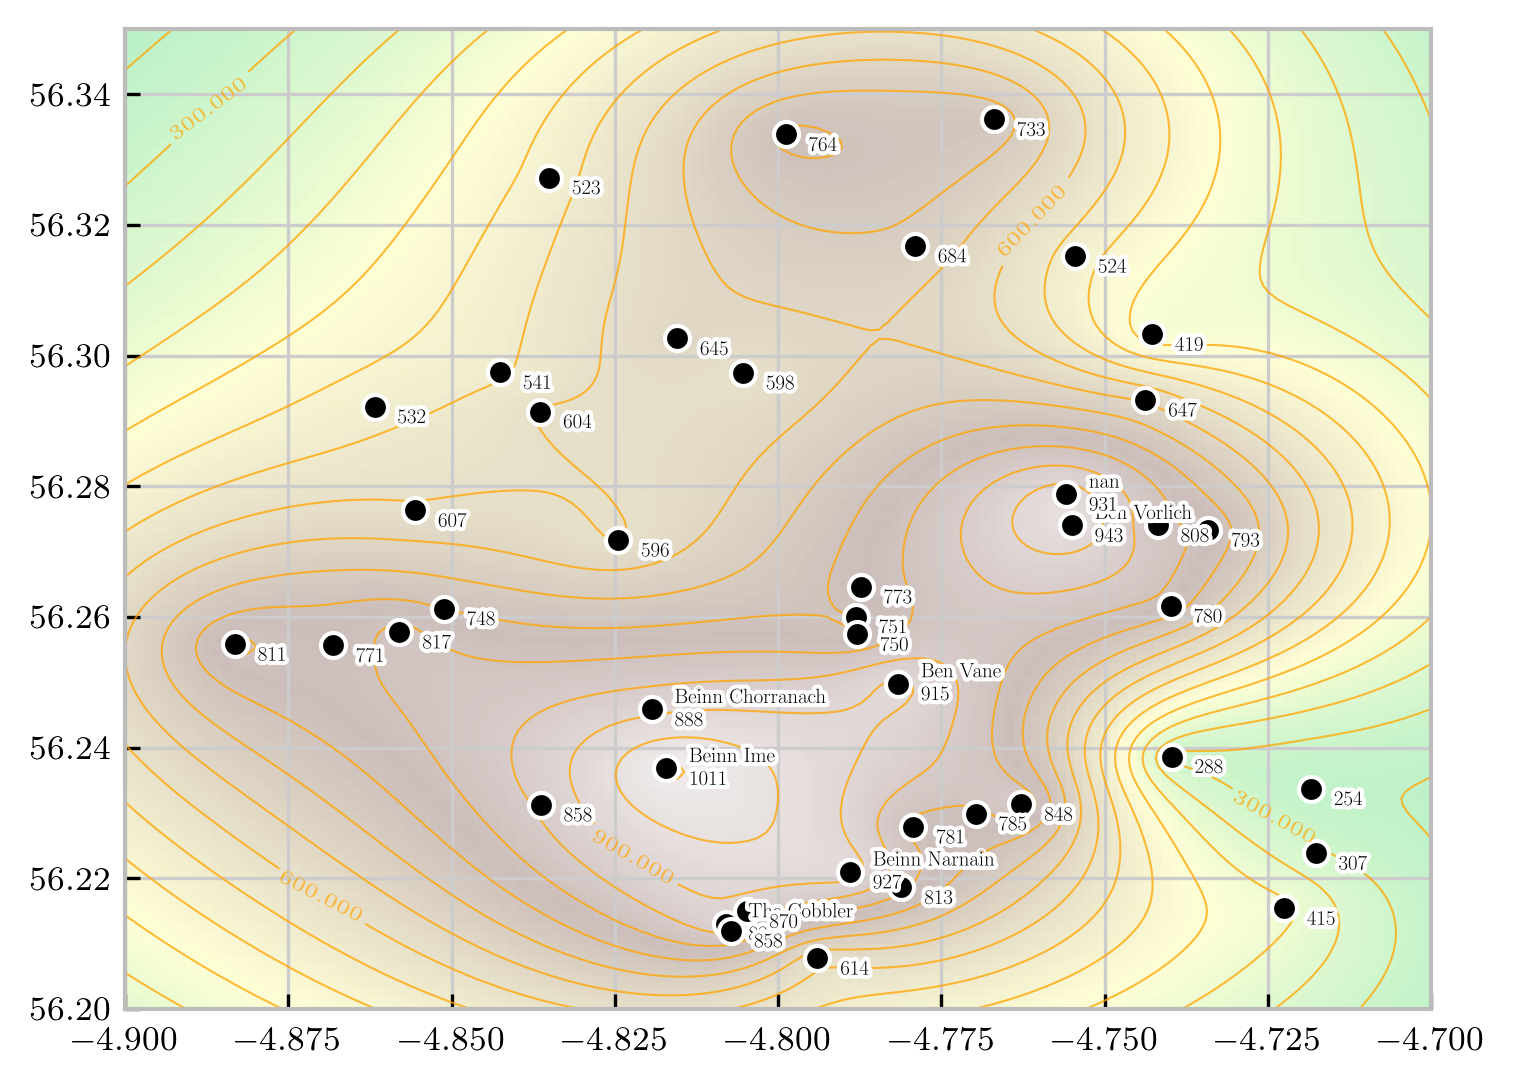

In [262]:

import matplotlib.patheffects as path_effects


f, ax = plt.subplots(1,1, figsize=thesis.figsize, dpi=300)
levels = np.arange(0, 1100, 50)
CS = ax.contour(lons, lats, (mu.reshape(150,150)), levels, linewidths=.5, colors='orange', alpha=0.75, zorder=1)
ax.clabel(CS, levels[::6], fontsize=5, inline=1, font="Raleway")
ax.imshow(mu.reshape(150,150), extent=[lons.min(), lons.max(), lats.min(), lats.max()], alpha=0.4, vmin=-200, vmax=1100,
          cmap='terrain', origin='lower')
ax.plot(hills['lon'], hills['lat'], 'o', markerfacecolor='k', markeredgecolor='w')
for hill in hills.iterrows():
    text = ax.text(0.0035+hill[1]['lon'], hill[1]['lat']-0.0025, int(hill[1]['height']), fontsize=5, zorder=100)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
    if hill[1]['height'] > 880:
        text = ax.text(0.0035+hill[1]['lon'], hill[1]['lat']+0.001, hill[1]['name'], fontsize=5)
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
#plt.colorbar()
f.tight_layout()
f.savefig("../figures/arrochar-alps.pdf")